In [ ]:
pip install yfinance pandas numpy matplotlib nltk praw

In [ ]:


import pandas as pd
import numpy as np
import yfinance as yf
import praw
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors


FEATURES = ['Compound', 'Positive', 'Negative', 'Neutral', 'Post_Count', 'Close', 'Volume', 'Returns']
TARGET = 'Target'


nltk.download('vader_lexicon')


sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
reddit = praw.Reddit(client_id='VRtxiNolzQ44cDJAXdLH7g',
                     client_secret='YCwtJ0jfXLAgSrBNkutPcp3HwlKuBg',
                     user_agent='Owais Raza', check_for_async=False)


In [ ]:
#dta ftch
def fetch_data():

    ticker = "TSLA"
    price_data = yf.download(ticker, period="1d", interval="1m", progress=False)
    price_data = price_data.reset_index()[['Datetime', 'Close', 'Volume']]
    price_data.columns = ['Date', 'Close', 'Volume']
    price_data['Date'] = pd.to_datetime(price_data['Date']).dt.tz_localize(None)
    return price_data, reddit.subreddit('stocks').new(limit=1000)

In [ ]:
print(price_data.head())
print(price_data.tail())


                 Date       Close   Volume
0 2025-03-17 13:30:00  241.815002  4817790
1 2025-03-17 13:31:00  240.996094   953405
2 2025-03-17 13:32:00  240.695007  1176276
3 2025-03-17 13:33:00  240.639999   735006
4 2025-03-17 13:34:00  239.639999   826750
                   Date       Close  Volume
382 2025-03-17 19:55:00  237.768005  522546
383 2025-03-17 19:56:00  237.759995  413212
384 2025-03-17 19:57:00  238.195297  393776
385 2025-03-17 19:58:00  238.279999  310694
386 2025-03-17 19:59:00  237.800003  911016


In [ ]:
def analyze_sentiment(posts):
    sentiment_data = []
    for post in posts:
        try:
            date = pd.to_datetime(post.created_utc, unit='s', utc=True).floor('min').tz_localize(None)
            scores = sid.polarity_scores(post.title + ' ' + post.selftext)
            sentiment_data.append({
                'Date': date,
                'Compound': scores['compound'],
                'Positive': scores['pos'],
                'Negative': scores['neg'],
                'Neutral': scores['neu'],
                'Post_Count': 1
            })
        except Exception: continue
    return pd.DataFrame(sentiment_data).groupby('Date').agg({
        'Compound': 'mean', 'Positive': 'mean', 'Negative': 'mean',
        'Neutral': 'mean', 'Post_Count': 'sum'
    }).reset_index() if sentiment_data else pd.DataFrame()

In [ ]:
def process_data(price_data, daily_sentiment):
    data = price_data.merge(
        daily_sentiment, on='Date', how='left'
    ).assign(
        **{col: lambda x: x[col].fillna(0) for col in ['Compound', 'Positive', 'Negative', 'Neutral']},
        Post_Count = lambda x: x['Post_Count'].fillna(0),
        Returns = lambda x: x['Close'].pct_change(),
        Target = lambda x: (x['Close'].shift(-1) > x['Close']).astype(int)
    )
    return data.dropna()

In [ ]:
def train_model(data):
    X_train, X_test, y_train, y_test = train_test_split(
        data[FEATURES], data[TARGET], test_size=0.2, shuffle=False
    )
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)


    probas = model.predict_proba(data[FEATURES])
    data['Pred_Proba'] = probas[:, 1]
    data['Prediction'] = model.predict(data[FEATURES])

    return data, model

In [ ]:
def generate_signals(data):

    data['Sentiment_MA'] = data['Compound'].rolling(3).mean().fillna(0)


    data['Price_MA_Fast'] = data['Close'].rolling(5).mean().fillna(data['Close'])
    data['Price_MA_Slow'] = data['Close'].rolling(15).mean().fillna(data['Close'])


    data['Sentiment_Signal'] = np.select([
        data['Compound'] > data['Sentiment_MA'] + 0.05,
        data['Compound'] < data['Sentiment_MA'] - 0.05
    ], [1, -1], default=0)


    data['Price_Signal'] = np.select([
        data['Price_MA_Fast'] > data['Price_MA_Slow'],
        data['Price_MA_Fast'] < data['Price_MA_Slow']
    ], [1, -1], default=0)


    data['Combined_Signal'] = np.where(
        data['Prediction'] == 1,
        np.maximum(data['Sentiment_Signal'] + data['Price_Signal'], -1),
        np.minimum(data['Sentiment_Signal'] + data['Price_Signal'], 1)
    )


    data['Final_Signal'] = np.select([
        (data['Combined_Signal'] >= 1) | (data['Pred_Proba'] > 0.65),
        (data['Combined_Signal'] <= -1) | (data['Pred_Proba'] < 0.35)
    ], [1, -1], default=0)


    data['Strategy_Returns'] = data['Final_Signal'].shift(1) * data['Returns'] * 0.5

    return data

Model Accuracy: 0.91
Sharpe Ratio: 6.09
Buy Signals: 256, Sell Signals: 128
Total Signals: 384 out of 386 data points


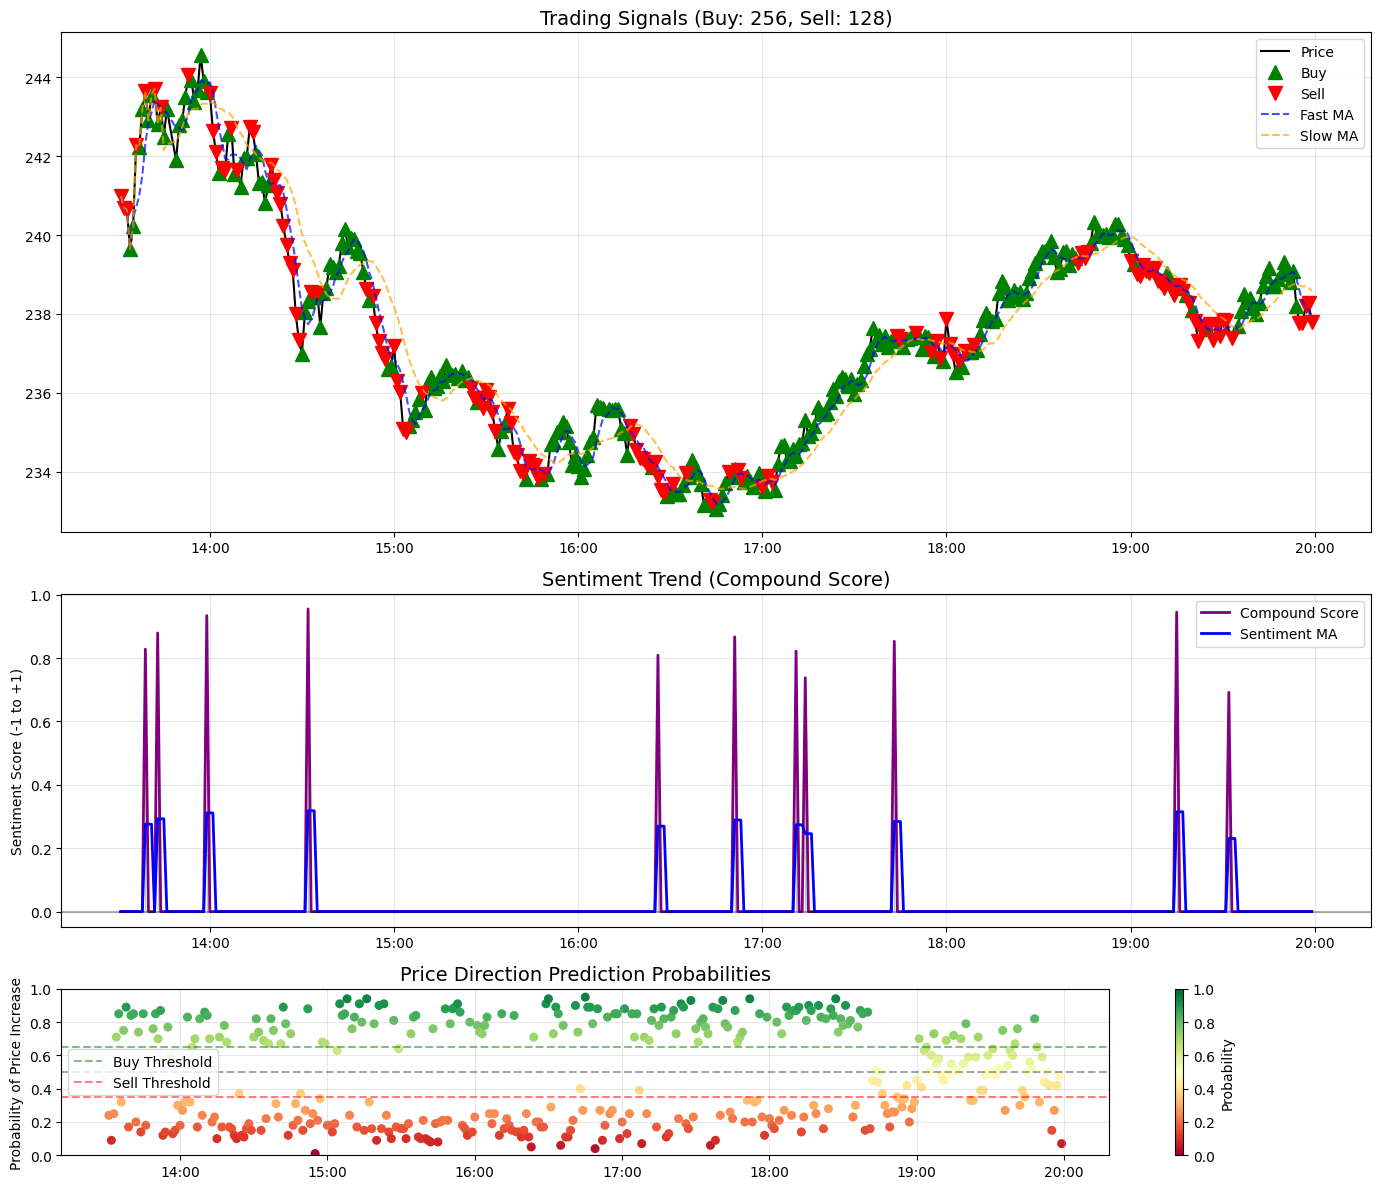

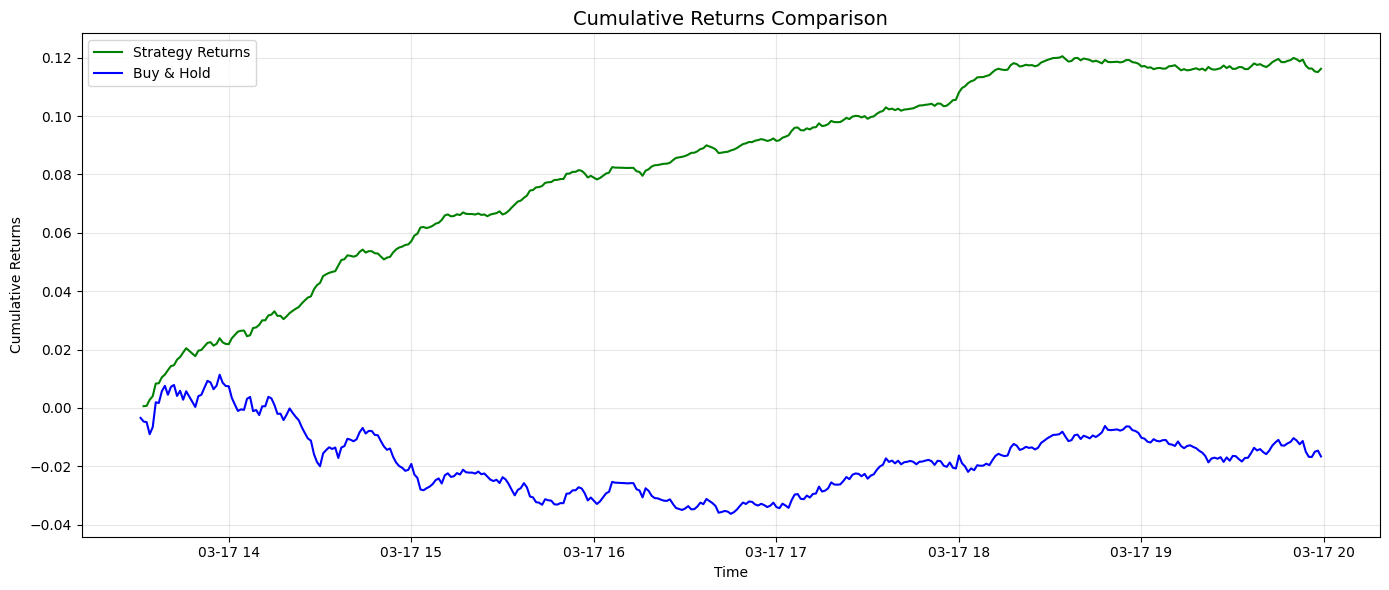

In [ ]:
if __name__ == "__main__":
    price_data, posts = fetch_data()
    daily_sentiment = analyze_sentiment(posts)

    if daily_sentiment.empty:
        print("No sentiment data available")
    else:
        data = process_data(price_data, daily_sentiment)
        data, model = train_model(data)
        data = generate_signals(data)


        sharpe_ratio = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std() * np.sqrt(252)
                        if data['Strategy_Returns'].std() != 0 else 0)


        buy_signals = data['Final_Signal'].value_counts().get(1, 0)
        sell_signals = data['Final_Signal'].value_counts().get(-1, 0)

        # Print model
        print(f"Model Accuracy: {model.score(data[FEATURES], data[TARGET]):.2f}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Buy Signals: {buy_signals}, Sell Signals: {sell_signals}")
        print(f"Total Signals: {buy_signals + sell_signals} out of {len(data)} data points")

        fig, axs = plt.subplots(3, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 2, 1]})


        axs[0].plot(data['Date'], data['Close'], label='Price', color='black')
        axs[0].plot(data[data['Final_Signal'] == 1]['Date'],
                 data['Close'][data['Final_Signal'] == 1], '^', markersize=10, color='g', label='Buy')
        axs[0].plot(data[data['Final_Signal'] == -1]['Date'],
                 data['Close'][data['Final_Signal'] == -1], 'v', markersize=10, color='r', label='Sell')


        axs[0].plot(data['Date'], data['Price_MA_Fast'], '--', color='blue', alpha=0.7, label='Fast MA')
        axs[0].plot(data['Date'], data['Price_MA_Slow'], '--', color='orange', alpha=0.7, label='Slow MA')

        axs[0].set_title(f"Trading Signals (Buy: {buy_signals}, Sell: {sell_signals})", fontsize=14)
        axs[0].legend()
        axs[0].grid(True, alpha=0.3)

        axs[1].plot(data['Date'], data['Compound'], linewidth=2, color='purple', label='Compound Score')
        axs[1].plot(data['Date'], data['Sentiment_MA'], linewidth=2, color='blue', label='Sentiment MA')
        axs[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axs[1].fill_between(data['Date'], data['Compound'], 0,
                         where=(data['Compound'] > 0), color='green', alpha=0.3)
        axs[1].fill_between(data['Date'], data['Compound'], 0,
                         where=(data['Compound'] < 0), color='red', alpha=0.3)
        axs[1].set_title("Sentiment Trend (Compound Score)", fontsize=14)
        axs[1].set_ylabel("Sentiment Score (-1 to +1)")
        axs[1].legend()
        axs[1].grid(True, alpha=0.3)


        sc = axs[2].scatter(data['Date'], data['Pred_Proba'],
                          c=data['Pred_Proba'], cmap='RdYlGn', vmin=0, vmax=1, s=30)
        axs[2].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
        axs[2].axhline(y=0.65, color='green', linestyle='--', alpha=0.5, label='Buy Threshold')
        axs[2].axhline(y=0.35, color='red', linestyle='--', alpha=0.5, label='Sell Threshold')
        axs[2].set_title("Price Direction Prediction Probabilities", fontsize=14)
        axs[2].set_ylabel("Probability of Price Increase")
        axs[2].set_ylim(0, 1)
        axs[2].legend()
        axs[2].grid(True, alpha=0.3)

        plt.colorbar(sc, ax=axs[2], label="Probability")

        # Format x-axis dates
        date_format = DateFormatter('%H:%M')
        for ax in axs:
            ax.xaxis.set_major_formatter(date_format)

        plt.tight_layout()
        plt.show()

        # Generate additional performance metrics
        cumulative_returns = (1 + data['Strategy_Returns']).cumprod() - 1
        benchmark_returns = (1 + data['Returns']).cumprod() - 1

        plt.figure(figsize=(14, 6))
        plt.plot(data['Date'], cumulative_returns, label='Strategy Returns', color='green')
        plt.plot(data['Date'], benchmark_returns, label='Buy & Hold', color='blue')
        plt.title("Cumulative Returns Comparison", fontsize=14)
        plt.xlabel("Time")
        plt.ylabel("Cumulative Returns")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
